<a href="https://colab.research.google.com/github/vlongle/Neurosimulation/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader

import time

from sklearn.neural_network import MLPRegressor
from sklearn.metrics.regression import mean_squared_error as mse
from sklearn.metrics.regression import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

In [0]:
# https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
root = "/content/drive/My Drive/summer2019/REU/Time Series/"

# filename = root  + "varyHitE.txt"
filename = root  + "examples_20000.txt"

data = np.loadtxt(filename)

In [0]:
y = data[:, 0].reshape(-1, 1)
X = data[:, 1:]
print(X.shape)
print(y.shape)

(20000, 400)
(20000, 1)


## Data Visualization

In [0]:
plt.rcParams["figure.figsize"] = (20,10) # width, height


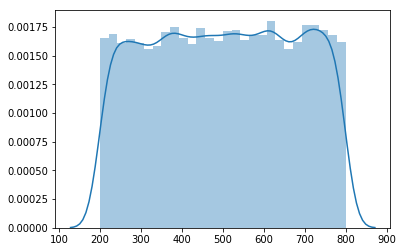

In [0]:
## distribution of y
sns.distplot(y)

In [0]:
## grab the lowest and highest HitI time series
data_low = X[np.argmin(y[:])]
data_high = X[np.argmax(y[:])]

In [0]:
total_low = data_low[:200] + data_low[200:]
total_high = data_high[:200] + data_high[200:]

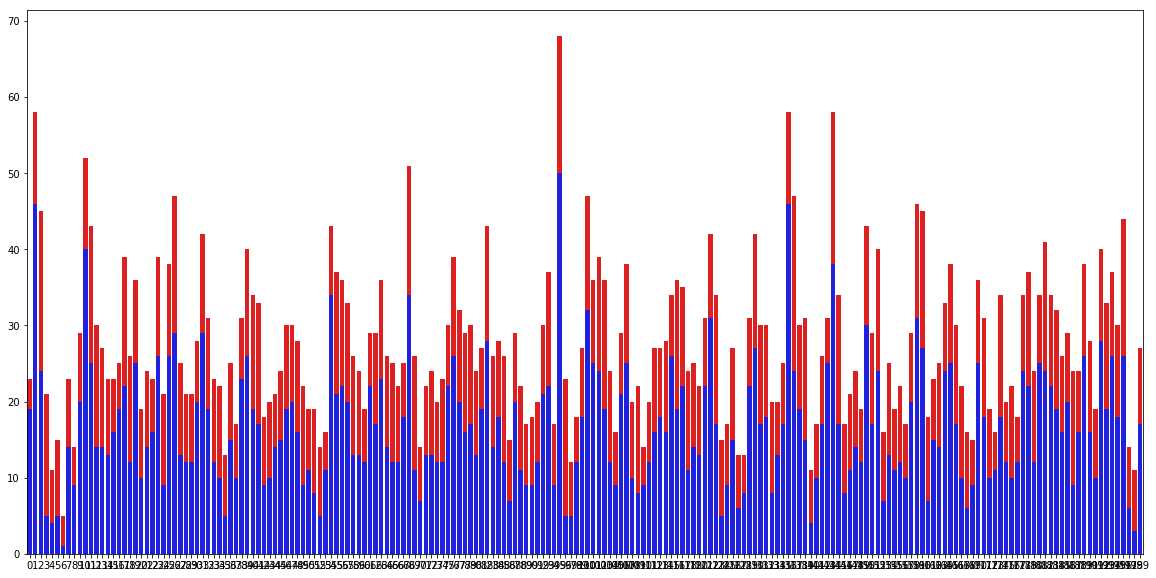

In [0]:
# Strong drive. Uniform
sns.barplot(list(range(0,200)), total_high, color='red')
sns.barplot(list(range(0,200)), data_high[:200], color='blue')

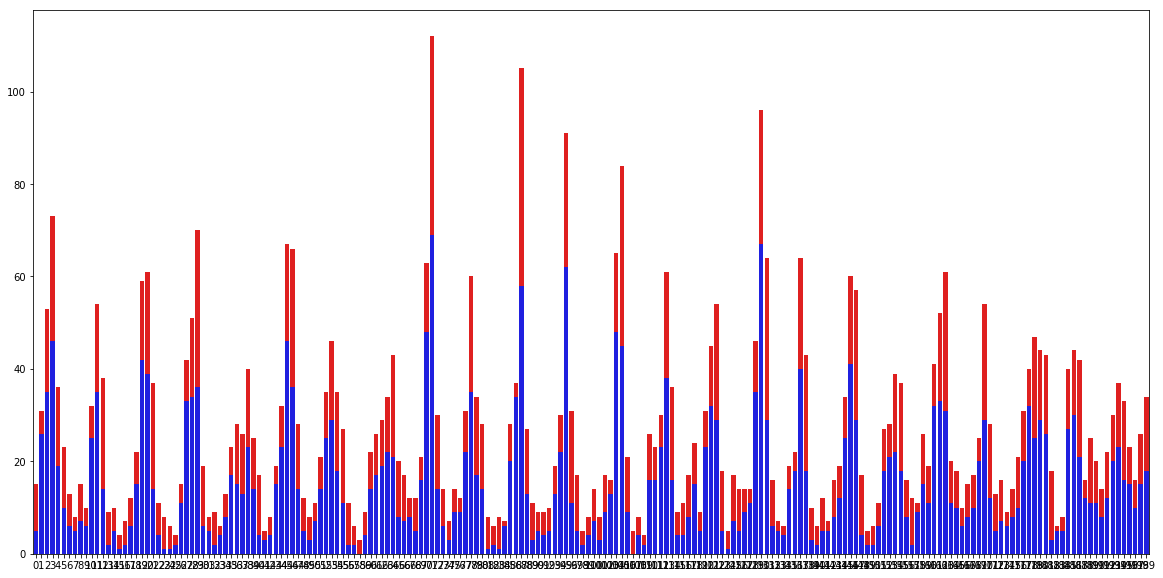

In [0]:
# Weak drive. Poralized. Synchronized
sns.barplot(list(range(0,200)), total_low, color='red')
sns.barplot(list(range(0,200)), data_low[:200], color='blue')

## Neural network

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.fc1 = nn.Linear(400,512)
    self.fc2 = nn.Linear(512,1024)
    self.fc3 = nn.Linear(1024,1024)

    self.out = nn.Linear(1024, 1)
    
  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))

    x = self.out(x)
    return x

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [0]:
X_test = torch.FloatTensor(X_test).to(device)


In [0]:
# X_test = torch.FloatTensor(X_test).to(device)

# dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

# # dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(dataset, batch_size=200)

In [0]:
def train(net, train_loader, X_test, y_test, learning_rate=1e-3, num_epochs=200):
  # L1 loss i.e MAE
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  net.to(device)
  
  losses = []
  maes = []
  
  for epoch in range(num_epochs):
    net.train()
    for i_batch, data in enumerate(train_loader, 0):
        X, Y = data
        X = X.to(device)
        Y = Y.to(device)
      
        optimizer.zero_grad()
        out = net(X)

        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
      with torch.no_grad():
        y_pred_test = net(X_test)
        cur_mae = mae(y_pred_test.cpu(), y_test)
        
        maes.append(cur_mae)
      
    losses.append(loss.item())
    
  return (losses, maes)
    

In [0]:


# plot learning curve. Vary datasets

# TO BE SET
step = 100
num_epochs = 300


learning_curve = np.arange(10, len(X_train), step=step)
print('training examples', learning_curve)

results = []

for train_size in learning_curve:
  dataset = TensorDataset(torch.FloatTensor(X_train[:train_size]), \
                          torch.FloatTensor(y_train[:train_size]))
  train_loader = DataLoader(dataset, batch_size=int(len(dataset)/10))
  
  net = Net()
  
  cur_losses, cur_maes = train(net, train_loader, X_test, y_test,\
                               num_epochs=num_epochs)
  results.append((cur_losses, cur_maes))

training examples [   10   110   210   310   410   510   610   710   810   910  1010  1110
  1210  1310  1410  1510  1610  1710  1810  1910  2010  2110  2210  2310
  2410  2510  2610  2710  2810  2910  3010  3110  3210  3310  3410  3510
  3610  3710  3810  3910  4010  4110  4210  4310  4410  4510  4610  4710
  4810  4910  5010  5110  5210  5310  5410  5510  5610  5710  5810  5910
  6010  6110  6210  6310  6410  6510  6610  6710  6810  6910  7010  7110
  7210  7310  7410  7510  7610  7710  7810  7910  8010  8110  8210  8310
  8410  8510  8610  8710  8810  8910  9010  9110  9210  9310  9410  9510
  9610  9710  9810  9910 10010 10110 10210 10310 10410 10510 10610 10710
 10810 10910 11010 11110 11210 11310 11410 11510 11610 11710 11810 11910
 12010 12110 12210 12310 12410 12510 12610 12710 12810 12910 13010 13110
 13210 13310 13410 13510 13610 13710 13810 13910 14010 14110 14210 14310
 14410 14510 14610 14710 14810 14910 15010 15110 15210 15310 15410 15510
 15610 15710 15810 15910 16010 16

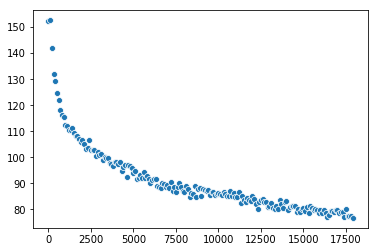

In [0]:
best_maes = [np.min(maes) for losses, maes in results]

sns.scatterplot(learning_curve, best_maes)

In [0]:
best_maes[-1]

81.38867568536376

In [0]:

# start = time.time()

# num_epochs = 1001
# learning_rate = 1e-4

# net = Net().to(device)


# # L1 loss i.e MAE
# criterion = nn.L1Loss()

# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# losses = []
# accuracies = []

# for epoch in range(num_epochs):
#     net.train()
#     for i_batch, data in enumerate(train_loader, 0):
#         X, Y = data
#         X = X.to(device)
#         Y = Y.to(device)
      
#         optimizer.zero_grad()
#         out = net(X)

#         loss = criterion(out, Y)
#         loss.backward()
#         optimizer.step()
    
#     if epoch % 10 == 0:
#       with torch.no_grad():
#         y_pred_test = net(X_test)
#         accuracies.append(mae(y_pred_test.cpu(), y_test))
      
#     losses.append(loss.item())
    

    
# end = time.time()

# print('done in', end-start)
# print(losses)

# plt.subplot(1, 2, 1)

# plt.plot(losses, marker="o")
# plt.title('Losses')

# plt.subplot(1, 2, 2)
# plt.plot(accuracies, marker="o", markeredgecolor="red")
# plt.title('Accuracies')

# print('accuracies', accuracies)

AttributeError: ignored

In [0]:

# # X_test = torch.FloatTensor(X_test).to(device)
# # X_train = torch.FloatTensor(X_train).to(device)

# with torch.no_grad():
#     net.eval()
#     y_pred_test = net(X_test)
#     y_pred_train = net(X_train)

    
# test_mae = mae(y_test, y_pred_test.cpu())

# train_mae = mae(y_train, y_pred_train.cpu())


# print('test_mae:', test_mae)

# print('train_mae:', train_mae)


test_mae: 51.074889450378414
train_mae: 28.574850671590166
